In [4]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os

In [6]:
# Load vmem simulation data
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(15)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

In [13]:
# Load simulation data with full morphologies
base_dir_plot_morph = '/Users/susannedahle/CellTypeDependenceElStim/imem_plot_data' # Available uppon request

# Imem plot data for selected frequencies contains morphology information for plotting
morph_plot_file_paths = [
    os.path.join(base_dir_plot_morph, f'plot_imem_{i}.npy')
    for i in range(8)
]

In [8]:
# Can only load some selected cells at a time for plotting
def load_plot_data_from_files(plot_file_paths, selected_cells):
    """Loads data for the selected cells from multiple .npy files. Ensures effective loading without using too much RAM"""
    data = {}
    
    for file_path in plot_file_paths:
        temp_data = np.load(file_path, allow_pickle=True).item()  # Load the .npy dictionary
        
        for cell in selected_cells:
            if cell in temp_data:
                data[cell] = temp_data[cell]  # Store only required cell data

        # Stop early if all selected cells have been found
        if len(data) == len(selected_cells):
            break  

    return data

In [9]:
selected_cells = ['L4_BP_bIR215_5', "L5_MC_bAC217_1", "L5_TTPC2_cADpyr232_3", "L5_NGC_bNAC219_5"]

cell_names = {
    'L4_BP_bIR215_5': 'L4 Bipolar cell (BP)',
    "L5_MC_bAC217_1": "L5 Martinotti cell (MC)",
    "L5_TTPC2_cADpyr232_3": "L5 Pyramidal cell (TTPC)",
    "L5_NGC_bNAC219_5": "L5 Neurogliaform cell (NGC)"
}

short_cell_names = {
    'L4_BP_bIR215_5': 'L4 BP',
    "L5_MC_bAC217_1": "L5 MC",
    "L5_TTPC2_cADpyr232_3": "L5 TTPC",
    "L5_NGC_bNAC219_5": "L5 NGC"
}

cell_vmem_colors = {
    'L4_BP_bIR215_5': "tab:pink",
    "L5_MC_bAC217_1": "tab:cyan",
    "L5_TTPC2_cADpyr232_3": "tab:olive",
    "L5_NGC_bNAC219_5": 'tab:brown'
}

cell_cdm_colors = {
    'L4_BP_bIR215_5': "tab:purple",
    "L5_MC_bAC217_1": "tab:blue",
    "L5_TTPC2_cADpyr232_3": "tab:green",
    "L5_NGC_bNAC219_5": 'tab:red'
}

In [16]:
def plot_morph_and_amp(imem_plot_file_paths, amp_data, amp_type, selected_cells):
    """Plot morphology examples (A) and amplitude spectra (B) with cleaner style."""
    
    imem_amp_dict = load_plot_data_from_files(imem_plot_file_paths, selected_cells)
    plt.rcParams['mathtext.fontset'] = 'stix'

    unique_cells = list(imem_amp_dict.keys())
    if selected_cells:
        unique_cells = [cell for cell in unique_cells if cell in selected_cells]

    num_cells = len(unique_cells)
    assert num_cells == 4, "This function expects exactly 4 selected cells for subplot A."

    # --- Figure layout: 2 rows, 4 columns ---
    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(
        2, 4,
        width_ratios=[0.8, 0.8, 0.8, 4],
        height_ratios=[1.6, 0.4],
        wspace=0.8, hspace=0.25
    )

    # --- Morphology subplots (same layout as original) ---
    axs_morph = []
    ax0 = fig.add_subplot(gs[:, 0])      # L4 BP
    ax1 = fig.add_subplot(gs[0, 1])      # L5 MC
    ax2 = fig.add_subplot(gs[:, 2])      # L5 TTPC
    ax3 = fig.add_subplot(gs[1, 1])      # L5 NGC
    axs_morph.extend([ax0, ax1, ax2, ax3])

    all_x, all_z = [], []

    # --- Plot morphologies ---
    for i, label in enumerate(unique_cells):
        # --- Move the L5 TTPC subplot (ax2) downward by ~200 µm in figure coordinates ---
        # Estimate figure height in data units for conversion:
        ax1 = axs_morph[1]  # L5 MC axis
        ax2 = axs_morph[2]  # L5 TTPC axis
        ax3 = axs_morph[3]  # L5 NGC axis
        fig.canvas.draw()  # Ensure layout positions are initialized

        # Estimate how much 200 µm corresponds to in figure-relative coordinates
        # (Use any morphology axis with known data extents)
        z_range = np.ptp(all_z) if len(all_z) > 0 else 1000  # fallback

        # Move MC downward
        move_fraction_mc = 19 / z_range
        pos_mc = ax1.get_position()
        new_pos_mc = [pos_mc.x0, pos_mc.y0 - move_fraction_mc, pos_mc.width, pos_mc.height]
        ax1.set_position(new_pos_mc)

        # Move TTPC downward
        move_fraction_ttpc = 7 / z_range  
        pos_ttpc = ax2.get_position()
        new_pos_ttpc = [pos_ttpc.x0, pos_ttpc.y0 - move_fraction_ttpc, pos_ttpc.width, pos_ttpc.height]
        ax2.set_position(new_pos_ttpc)

        # Move NGC upward
        move_fraction_ngc = 40 / z_range
        pos_ngc = ax3.get_position()
        new_pos_ngc = [pos_ngc.x0, pos_ngc.y0 + move_fraction_ngc, pos_ngc.width, pos_ngc.height]
        ax3.set_position(new_pos_ngc)

        
        ax = axs_morph[i]
        cell_data = imem_amp_dict[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        color = cell_vmem_colors[label]

        # Draw morphology
        for idx in range(totnsegs):
            ax.plot(x[idx], z[idx], c=color, lw=1)

        # Soma marker
        ax.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0],
                'o', color='black', markersize=3)

        # Collect extents for scale bar placement
        all_x.extend(x.flatten())
        all_z.extend(z.flatten())

        # Clean style: no axes or frame
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.set_aspect('equal', adjustable='box')

        # Add cell title
        ax.set_title(f'{cell_names[label]}', fontsize=7)
    
    # --- Ensure shared y-axis limits across morphology plots ---
    all_x = np.array(all_x)

    # Determine common axis limits
    x_min, x_max = np.min(all_x), np.max(all_x)

    # Apply same limits to all morphology subplots
    for ax in axs_morph:
        ax.set_xlim(x_min, x_max)

    # --- Shared scale bar ---
    scale_bar_length = 100  # µm
    
    # Use the specific limits of ax0's data for placement, not the full all_x range.
    # Since all morphology axes share the same x-limits:
    ax_xlim = ax0.get_xlim()
    ax_ylim = ax0.get_ylim()

    # Determine scale bar x-position (e.g., starting 10% from the left edge of ax0)
    # The length should be exactly 50 µm in data units.
    scale_bar_x_start = ax_xlim[0] + 0.10 * (ax_xlim[1] - ax_xlim[0])
    scale_bar_x_end = scale_bar_x_start + scale_bar_length
    
    # Determine scale bar y-position (e.g., 5% below the bottom edge of the morphology)
    # If all_z is defined, use that for a common visual bottom, otherwise use ax_ylim.
    if len(all_z) > 0:
        scale_bar_y = np.min(all_z) - 0.05 * np.ptp(all_z)
    else:
        # Fallback if no data was collected, or use a fixed offset from the bottom limit
        scale_bar_y = ax_ylim[0] - 200 
    
    # Adjust y-position if it falls outside the current y-limits of ax0 to ensure it's visible.
    # Note: Setting y-limits for ax0 is done later in the original code, 
    # but since it's an L4 BP cell which is typically not very tall, we'll draw it
    # *below* the morphology data.
    
    # Put scale bar on bottom-left subplot (L4 BP) -> ax0
    ax0.plot([scale_bar_x_start, scale_bar_x_end],
             [scale_bar_y, scale_bar_y], color='k', lw=1)
    
    # Text position: centered horizontally, slightly below the bar.
    ax0.text((scale_bar_x_start + scale_bar_x_end) / 2, 
             scale_bar_y - 40, # 40 µm offset below the bar
             f'{scale_bar_length} µm', fontsize=9,
             va='top', ha='center')

    # Ensure all morphology plots can contain the scale bar if placed far below.
    # The original code's y-limits were determined implicitly by the plotted data.
    # We should update the limits of ax0 to include the scale bar.
    current_ymin, current_ymax = ax0.get_ylim()
    if scale_bar_y - 10 < current_ymin:
        ax0.set_ylim(scale_bar_y - 10, current_ymax)


    # --- Add subplot label A ---
    ax0.text(-0.35, 1.2, 'A', transform=ax0.transAxes,
             fontsize=10, fontweight='bold')

    # --- Subplot B: amplitude spectra ---
    axB = fig.add_subplot(gs[:, 3])

    for cell_name, data in amp_data.items():
        if cell_name in selected_cells:
            if amp_type == 'soma_amp':
                frequencies = data['freq']
                ylab = 'Soma $V_\mathrm{m}$ Amplitude [mV]'
                color = cell_vmem_colors[cell_name]
            elif amp_type == 'cdm':
                frequencies = data['frequency']
                ylab = "Dipole Moment Amplitude [A·m]"
                color = cell_cdm_colors[cell_name]

            amplitudes = data[amp_type]
            axB.loglog(frequencies, amplitudes,
                       label=f'{short_cell_names[cell_name]}', color=color)

    axB.set_xlabel('Frequency [Hz]')
    axB.set_ylabel(ylab)
    axB.set_xlim(left=frequencies[0], right=frequencies[-1])
    axB.grid(linestyle='--', linewidth=0.5)
    axB.legend(loc='upper right', ncol=1, fontsize=7, frameon=False)
    axB.text(-0.1, 1.1, 'B', transform=axB.transAxes,
             fontsize=10, fontweight='bold')

    # Optional: equal aspect for amplitude plot
    axB.set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.savefig(
        f'/Users/susannedahle/Documents/Master/Code/Plots_artikkel/neocortical/Morph_and_{amp_type}_example_cells.png',
        dpi=300, bbox_inches='tight'
    )
    plt.show()


<>:158: SyntaxWarning: invalid escape sequence '\m'
<>:158: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_18627/4110056479.py:158: SyntaxWarning: invalid escape sequence '\m'
  ylab = 'Soma $V_\mathrm{m}$ Amplitude [mV]'


/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_18627/4110056479.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


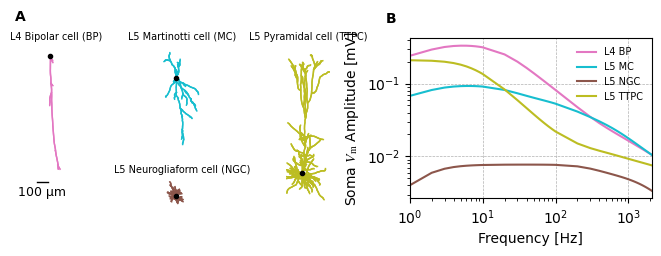

In [17]:
plot_morph_and_amp(morph_plot_file_paths, vmem_amp_data, 'soma_amp', selected_cells)